In [43]:
!pip install calplot
!pip install prophet

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calplot
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.serialize import model_to_json, model_from_json

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

In [45]:
df = pd.read_csv("city_temperature.csv")
df


Region  Country                   State                  City  \
0               Africa  Algeria                     NaN               Algiers   
1               Africa  Algeria                     NaN               Algiers   
2               Africa  Algeria                     NaN               Algiers   
3               Africa  Algeria                     NaN               Algiers   
4               Africa  Algeria                     NaN               Algiers   
...                ...      ...                     ...                   ...   
2906322  North America       US  Additional Territories  San Juan Puerto Rico   
2906323  North America       US  Additional Territories  San Juan Puerto Rico   
2906324  North America       US  Additional Territories  San Juan Puerto Rico   
2906325  North America       US  Additional Territories  San Juan Puerto Rico   
2906326  North America       US  Additional Territories  San Juan Puerto Rico   

         Month  Day  Year  AvgTemperature  
0            1    1  1995            64.2  
1            1    2  1995            49.4  
2            1    3  1995            48.8  
3            1    4  1995            46.4  
4            1    5  1995            47.9  
...        ...  ...   ...             ...  
2906322      7   27  2013            82.4  
2906323      7   28  2013            81.6  
2906324      7   29  2013            84.2  
2906325      7   30  2013            83.8  
2906326      7   31  2013            83.6  

[2906327 rows x 8 columns]

In [46]:
df = df[df["Country"] == "India"]

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37063 entries, 312523 to 349585
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Region          37063 non-null  object 
 1   Country         37063 non-null  object 
 2   State           0 non-null      object 
 3   City            37063 non-null  object 
 4   Month           37063 non-null  int64  
 5   Day             37063 non-null  int64  
 6   Year            37063 non-null  int64  
 7   AvgTemperature  37063 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 2.5+ MB


In [48]:
df.size


296504

In [49]:
df.isnull().sum()

Region                0
Country               0
State             37063
City                  0
Month                 0
Day                   0
Year                  0
AvgTemperature        0
dtype: int64

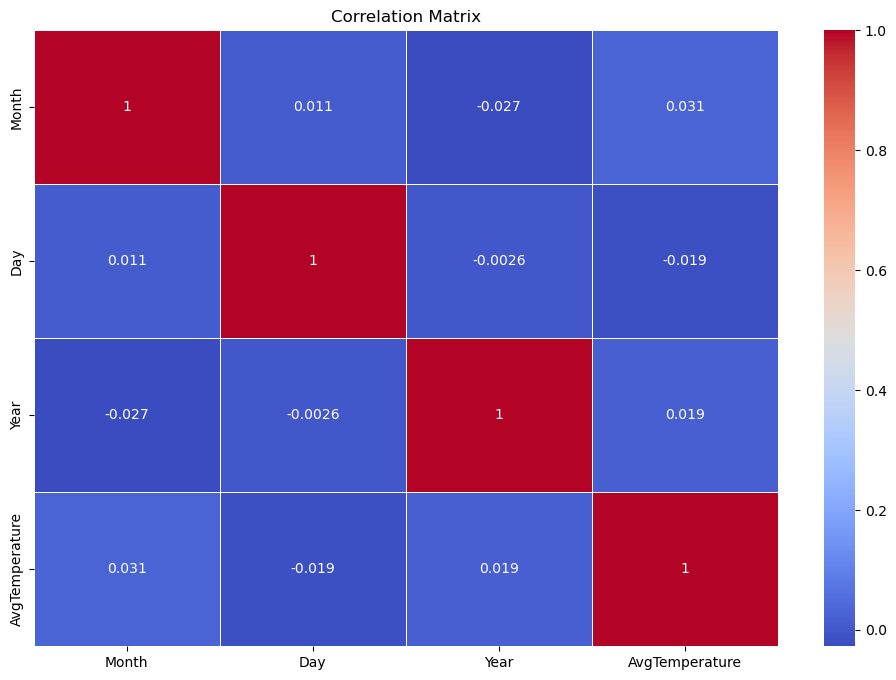

In [50]:
# Visualize the correlation matrix using a heatmap
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<AxesSubplot:>

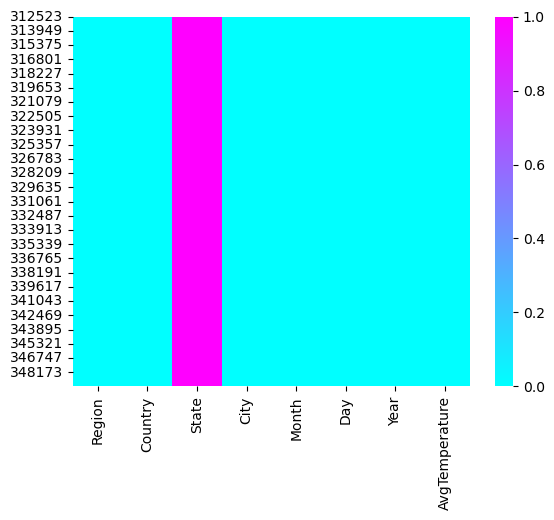

In [51]:
sns.heatmap(df.isnull(), cmap = "cool")

In [52]:
df.drop("State", axis = 1, inplace = True)

In [53]:
df.City.unique()

array(['Bombay (Mumbai)', 'Calcutta', 'Chennai (Madras)', 'Delhi'],
      dtype=object)

In [54]:
df = df[df["City"] == 'Bombay (Mumbai)']
df

Region Country             City  Month  Day  Year  AvgTemperature
312523   Asia   India  Bombay (Mumbai)      1    1  1995            71.8
312524   Asia   India  Bombay (Mumbai)      1    2  1995            72.0
312525   Asia   India  Bombay (Mumbai)      1    3  1995            70.3
312526   Asia   India  Bombay (Mumbai)      1    4  1995            69.7
312527   Asia   India  Bombay (Mumbai)      1    5  1995            71.3
...       ...     ...              ...    ...  ...   ...             ...
321784   Asia   India  Bombay (Mumbai)      5    9  2020            87.3
321785   Asia   India  Bombay (Mumbai)      5   10  2020            87.7
321786   Asia   India  Bombay (Mumbai)      5   11  2020            88.1
321787   Asia   India  Bombay (Mumbai)      5   12  2020            87.3
321788   Asia   India  Bombay (Mumbai)      5   13  2020            85.0

[9266 rows x 7 columns]

In [55]:
df.describe().T

count         mean        std     min     25%     50%  \
Month           9266.0     6.468919   3.457327     1.0     3.0     6.0   
Day             9266.0    15.717354   8.801516     1.0     8.0    16.0   
Year            9266.0  2007.188215   7.325356  1995.0  2001.0  2007.0   
AvgTemperature  9266.0    81.531729  10.989813   -99.0    79.9    82.6   

                   75%     max  
Month              9.0    12.0  
Day               23.0    31.0  
Year            2014.0  2020.0  
AvgTemperature    84.7    92.6

In [56]:
df["datetime"] = df.apply(lambda x : datetime.datetime(x["Year"], x["Month"], x["Day"], 0, 0, 0, 0), axis=1)
df.index = df["datetime"].values
df

Region Country             City  Month  Day  Year  AvgTemperature  \
1995-01-01   Asia   India  Bombay (Mumbai)      1    1  1995            71.8   
1995-01-02   Asia   India  Bombay (Mumbai)      1    2  1995            72.0   
1995-01-03   Asia   India  Bombay (Mumbai)      1    3  1995            70.3   
1995-01-04   Asia   India  Bombay (Mumbai)      1    4  1995            69.7   
1995-01-05   Asia   India  Bombay (Mumbai)      1    5  1995            71.3   
...           ...     ...              ...    ...  ...   ...             ...   
2020-05-09   Asia   India  Bombay (Mumbai)      5    9  2020            87.3   
2020-05-10   Asia   India  Bombay (Mumbai)      5   10  2020            87.7   
2020-05-11   Asia   India  Bombay (Mumbai)      5   11  2020            88.1   
2020-05-12   Asia   India  Bombay (Mumbai)      5   12  2020            87.3   
2020-05-13   Asia   India  Bombay (Mumbai)      5   13  2020            85.0   

             datetime  
1995-01-01 1995-01-01  
1995-01-02 1995-01-02  
1995-01-03 1995-01-03  
1995-01-04 1995-01-04  
1995-01-05 1995-01-05  
...               ...  
2020-05-09 2020-05-09  
2020-05-10 2020-05-10  
2020-05-11 2020-05-11  
2020-05-12 2020-05-12  
2020-05-13 2020-05-13  

[9266 rows x 8 columns]

In [57]:
df = df[df["AvgTemperature"] != -99]
df["TempInC"] = df["AvgTemperature"].apply(lambda x : (x-32)/1.8)
df

Region Country             City  Month  Day  Year  AvgTemperature  \
1995-01-01   Asia   India  Bombay (Mumbai)      1    1  1995            71.8   
1995-01-02   Asia   India  Bombay (Mumbai)      1    2  1995            72.0   
1995-01-03   Asia   India  Bombay (Mumbai)      1    3  1995            70.3   
1995-01-04   Asia   India  Bombay (Mumbai)      1    4  1995            69.7   
1995-01-05   Asia   India  Bombay (Mumbai)      1    5  1995            71.3   
...           ...     ...              ...    ...  ...   ...             ...   
2020-05-09   Asia   India  Bombay (Mumbai)      5    9  2020            87.3   
2020-05-10   Asia   India  Bombay (Mumbai)      5   10  2020            87.7   
2020-05-11   Asia   India  Bombay (Mumbai)      5   11  2020            88.1   
2020-05-12   Asia   India  Bombay (Mumbai)      5   12  2020            87.3   
2020-05-13   Asia   India  Bombay (Mumbai)      5   13  2020            85.0   

             datetime    TempInC  
1995-01-01 1995-01-01  22.111111  
1995-01-02 1995-01-02  22.222222  
1995-01-03 1995-01-03  21.277778  
1995-01-04 1995-01-04  20.944444  
1995-01-05 1995-01-05  21.833333  
...               ...        ...  
2020-05-09 2020-05-09  30.722222  
2020-05-10 2020-05-10  30.944444  
2020-05-11 2020-05-11  31.166667  
2020-05-12 2020-05-12  30.722222  
2020-05-13 2020-05-13  29.444444  

[9236 rows x 9 columns]

In [58]:
df.dtypes

Region                    object
Country                   object
City                      object
Month                      int64
Day                        int64
Year                       int64
AvgTemperature           float64
datetime          datetime64[ns]
TempInC                  float64
dtype: object

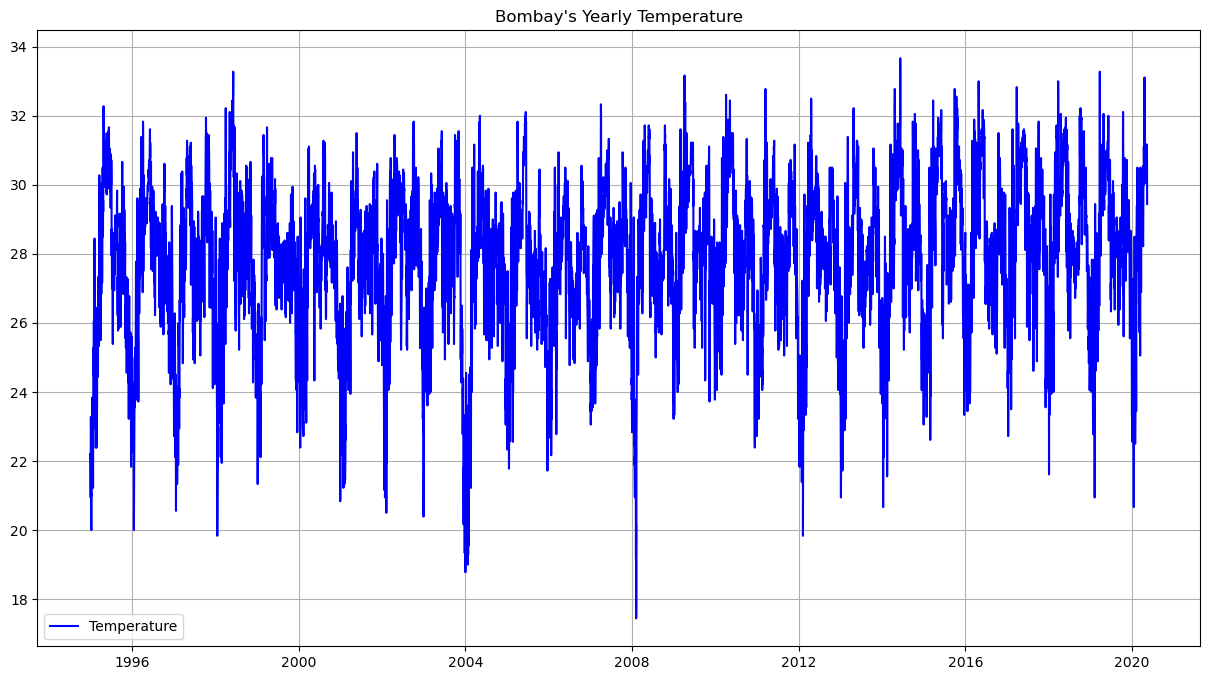

In [59]:
plt.figure(figsize=(15, 8))
plt.title("Bombay's Yearly Temperature")
plt.plot(df['datetime'], df['TempInC'], color = 'blue', linewidth = 1.5, label = "Temperature")
plt.grid()
plt.legend(loc ="lower left")

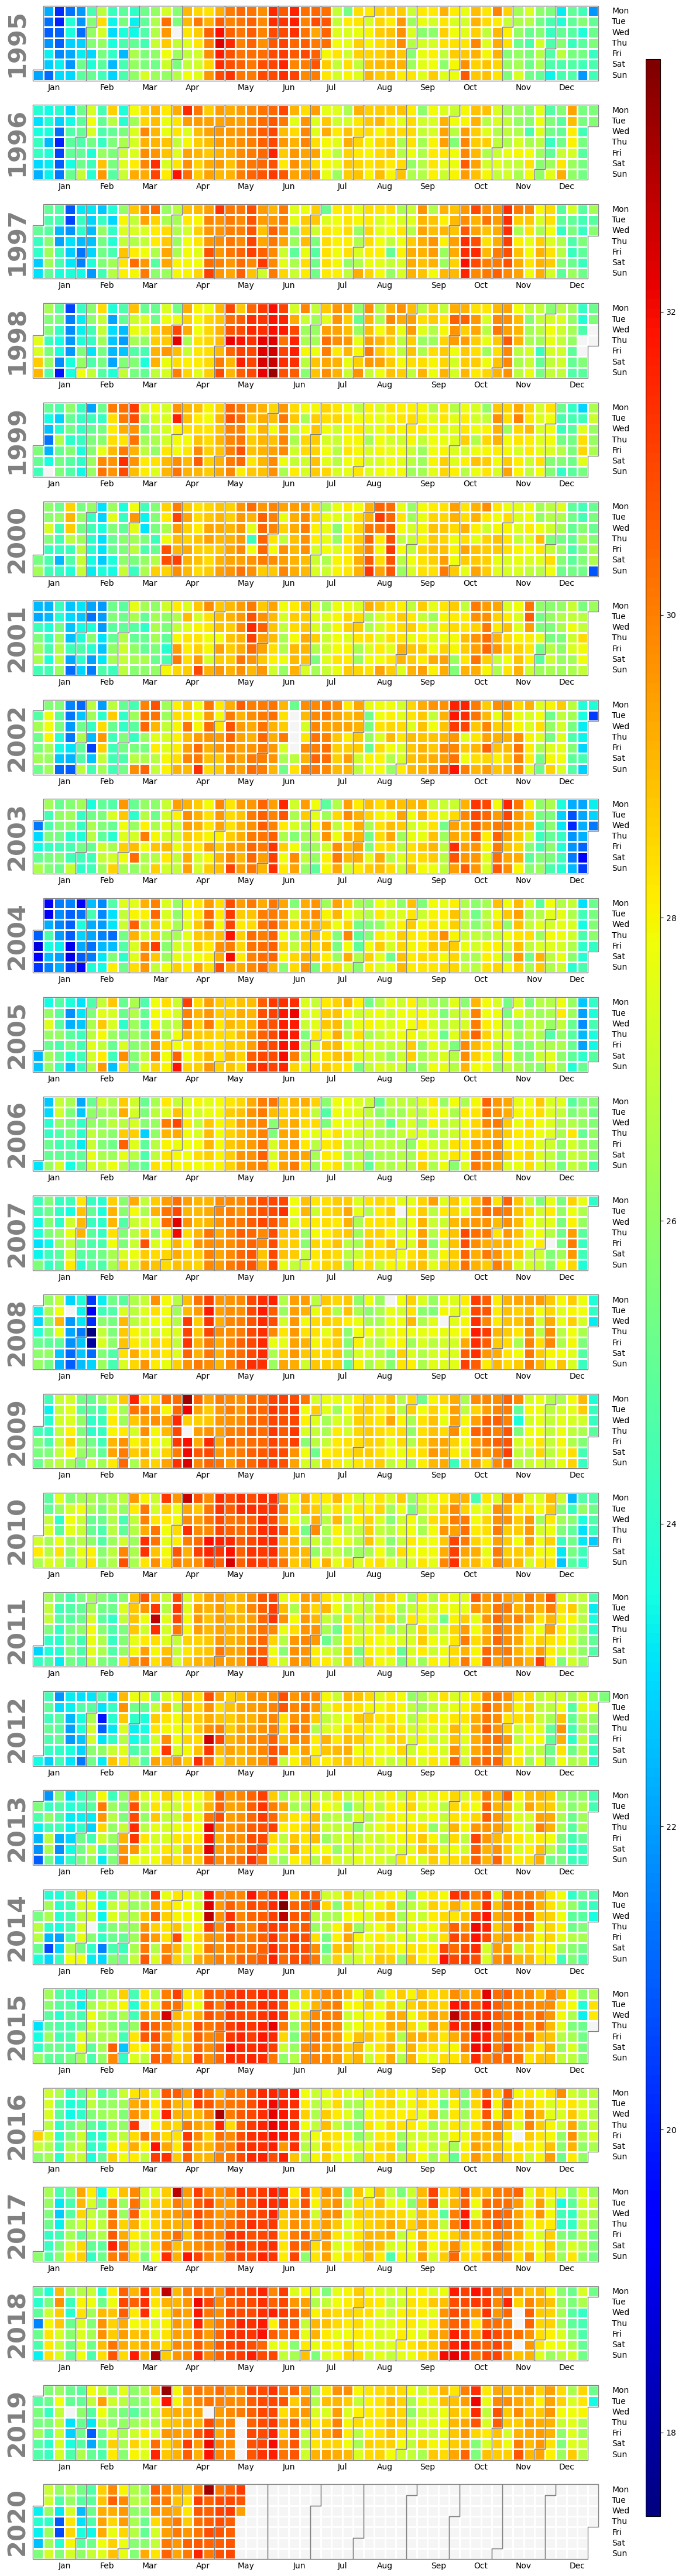

In [60]:
fig = calplot.calplot(df["TempInC"], how = "mean", cmap='jet')

# Making a New Dataframe with Date & Temperature in Celsius Only for the Prophet Model

In [61]:
n_df = df[['datetime', 'TempInC']]
n_df

datetime    TempInC
1995-01-01 1995-01-01  22.111111
1995-01-02 1995-01-02  22.222222
1995-01-03 1995-01-03  21.277778
1995-01-04 1995-01-04  20.944444
1995-01-05 1995-01-05  21.833333
...               ...        ...
2020-05-09 2020-05-09  30.722222
2020-05-10 2020-05-10  30.944444
2020-05-11 2020-05-11  31.166667
2020-05-12 2020-05-12  30.722222
2020-05-13 2020-05-13  29.444444

[9236 rows x 2 columns]

In [62]:
n_df.rename(columns = {'datetime' :'ds', 'TempInC' : 'y'}, inplace = True)

# Prophet Mode

In [63]:
model = Prophet()
model.fit(n_df)

19:21:10 - cmdstanpy - INFO - Chain [1] start processing
19:21:13 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
df_future = model.make_future_dataframe(periods = 850)
forecast = model.predict(df_future)

In [65]:
forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0     1995-01-01  27.252022   22.670811   26.063240    27.252022    27.252022   
1     1995-01-02  27.252470   22.634485   25.966204    27.252470    27.252470   
2     1995-01-03  27.252918   22.486998   26.093080    27.252918    27.252918   
3     1995-01-04  27.253367   22.455738   25.931191    27.253367    27.253367   
4     1995-01-05  27.253815   22.425663   25.936497    27.253815    27.253815   
...          ...        ...         ...         ...          ...          ...   
10081 2022-09-06  28.487168   26.482754   30.154281    28.120867    28.887045   
10082 2022-09-07  28.487161   26.498060   30.277686    28.119606    28.888352   
10083 2022-09-08  28.487154   26.450913   30.050969    28.118346    28.889660   
10084 2022-09-09  28.487147   26.515942   30.264989    28.117086    28.891713   
10085 2022-09-10  28.487139   26.523246   30.141543    28.115825    28.893839   

       additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0           -2.941091             -2.941091             -2.941091  0.012074   
1           -2.951184             -2.951184             -2.951184  0.037021   
2           -2.996357             -2.996357             -2.996357  0.023667   
3           -3.061889             -3.061889             -3.061889 -0.012944   
4           -3.115616             -3.115616             -3.115616 -0.040325   
...               ...                   ...                   ...       ...   
10081       -0.140468             -0.140468             -0.140468  0.023667   
10082       -0.174789             -0.174789             -0.174789 -0.012944   
10083       -0.196374             -0.196374             -0.196374 -0.040325   
10084       -0.159460             -0.159460             -0.159460 -0.012780   
10085       -0.140434             -0.140434             -0.140434 -0.006714   

       weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0          0.012074      0.012074 -2.953165     -2.953165     -2.953165   
1          0.037021      0.037021 -2.988206     -2.988206     -2.988206   
2          0.023667      0.023667 -3.020024     -3.020024     -3.020024   
3         -0.012944     -0.012944 -3.048946     -3.048946     -3.048946   
4         -0.040325     -0.040325 -3.075291     -3.075291     -3.075291   
...             ...           ...       ...           ...           ...   
10081      0.023667      0.023667 -0.164135     -0.164135     -0.164135   
10082     -0.012944     -0.012944 -0.161845     -0.161845     -0.161845   
10083     -0.040325     -0.040325 -0.156049     -0.156049     -0.156049   
10084     -0.012780     -0.012780 -0.146680     -0.146680     -0.146680   
10085     -0.006714     -0.006714 -0.133720     -0.133720     -0.133720   

       multiplicative_terms  multiplicative_terms_lower  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   
...                     ...                         ...   
10081                   0.0                         0.0   
10082                   0.0                         0.0   
10083                   0.0                         0.0   
10084                   0.0                         0.0   
10085                   0.0                         0.0   

       multiplicative_terms_upper       yhat  
0                             0.0  24.310931  
1                             0.0  24.301286  
2                             0.0  24.256561  
3                             0.0  24.191477  
4                             0.0  24.138199  
...                           ...        ...  
10081                         0.0  28.346700  
10082                         0.0  28.312372  
10083                         0.0  28.290780  
10084       

In [66]:
pred = forecast.copy()


# Forecsting the Temperature


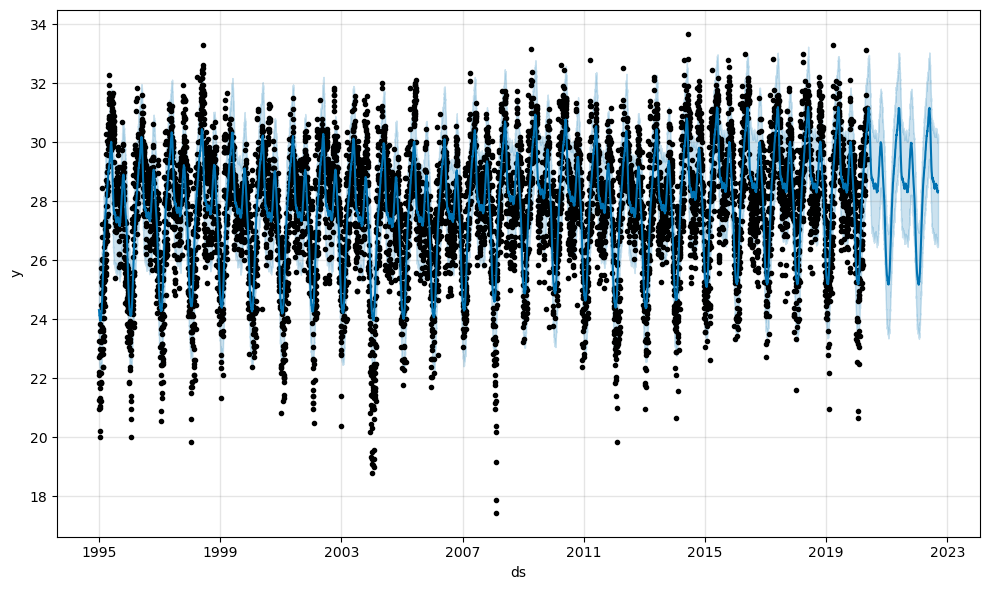

In [67]:
figure1 = model.plot(forecast)

In [68]:
plot_plotly(model, forecast)

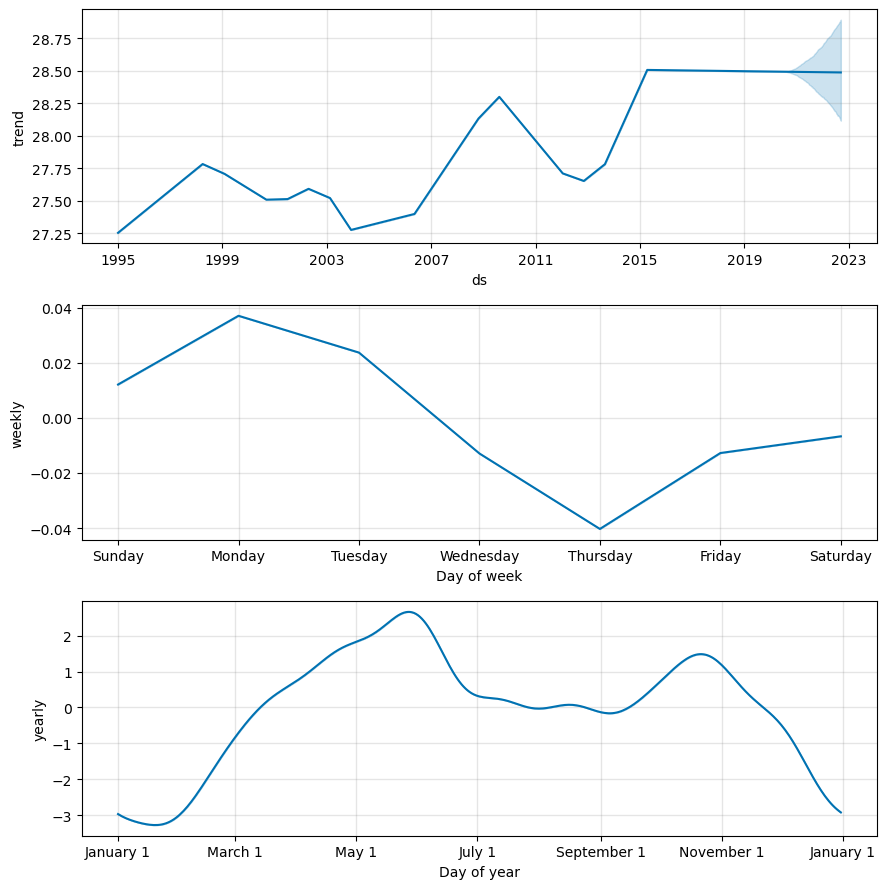

In [69]:
figure2 = model.plot_components(forecast)

In [70]:
plot_components_plotly(model, forecast)

In [71]:
pred.index = pred["ds"].values

In [72]:
pred = pred[pred["ds"] > "2020-05-13"]
pred

ds      trend  yhat_lower  yhat_upper  trend_lower  \
2020-05-14 2020-05-14  28.493258   29.032084   32.406255    28.493258   
2020-05-15 2020-05-15  28.493251   29.083080   32.595844    28.493251   
2020-05-16 2020-05-16  28.493244   29.016681   32.504060    28.493244   
2020-05-17 2020-05-17  28.493237   29.090199   32.570863    28.493237   
2020-05-18 2020-05-18  28.493230   29.286306   32.865444    28.493230   
...               ...        ...         ...         ...          ...   
2022-09-06 2022-09-06  28.487168   26.482754   30.154281    28.120867   
2022-09-07 2022-09-07  28.487161   26.498060   30.277686    28.119606   
2022-09-08 2022-09-08  28.487154   26.450913   30.050969    28.118346   
2022-09-09 2022-09-09  28.487147   26.515942   30.264989    28.117086   
2022-09-10 2022-09-10  28.487139   26.523246   30.141543    28.115825   

            trend_upper  additive_terms  additive_terms_lower  \
2020-05-14    28.493258        2.192419              2.192419   
2020-05-15    28.493251        2.263961              2.263961   
2020-05-16    28.493244        2.314784              2.314784   
2020-05-17    28.493237        2.378508              2.378508   
2020-05-18    28.493230        2.447908              2.447908   
...                 ...             ...                   ...   
2022-09-06    28.887045       -0.140468             -0.140468   
2022-09-07    28.888352       -0.174789             -0.174789   
2022-09-08    28.889660       -0.196374             -0.196374   
2022-09-09    28.891713       -0.159460             -0.159460   
2022-09-10    28.893839       -0.140434             -0.140434   

            additive_terms_upper    weekly  weekly_lower  weekly_upper  \
2020-05-14              2.192419 -0.040325     -0.040325     -0.040325   
2020-05-15              2.263961 -0.012780     -0.012780     -0.012780   
2020-05-16              2.314784 -0.006714     -0.006714     -0.006714   
2020-05-17              2.378508  0.012074      0.012074      0.012074   
2020-05-18              2.447908  0.037021      0.037021      0.037021   
...                          ...       ...           ...           ...   
2022-09-06             -0.140468  0.023667      0.023667      0.023667   
2022-09-07             -0.174789 -0.012944     -0.012944     -0.012944   
2022-09-08             -0.196374 -0.040325     -0.040325     -0.040325   
2022-09-09             -0.159460 -0.012780     -0.012780     -0.012780   
2022-09-10             -0.140434 -0.006714     -0.006714     -0.006714   

              yearly  yearly_lower  yearly_upper  multiplicative_terms  \
2020-05-14  2.232743      2.232743      2.232743                   0.0   
2020-05-15  2.276740      2.276740      2.276740                   0.0   
2020-05-16  2.321499      2.321499      2.321499                   0.0   
2020-05-17  2.366434      2.366434      2.366434                   0.0   
2020-05-18  2.410886      2.410886      2.410886                   0.0   
...              ...           ...           ...                   ...   
2022-09-06 -0.164135     -0.164135     -0.164135                   0.0   
2022-09-07 -0.161845     -0.161845     -0.161845                   0.0   
2022-09-08 -0.156049     -0.156049     -0.156049                   0.0   
2022-09-09 -0.146680     -0.146680     -0.146680                   0.0   
2022-09-10 -0.133720     -0.133720     -0.133720                   0.0   

            multiplicative_terms_lower  multiplicative_terms_upper       yhat  
2020-05-14                         0.0                         0.0  30.685677  
2020-05-15                         0.0                         0.0  30.757212  
2020-05-16                         0.0                         0.0  30.808028  
2020-05-17                         0.0                         0.0  30.871745  
2020-05-18                         0.0                         0.0  30.941138  
...                                ...                         ...        ...  
2022-09-06             

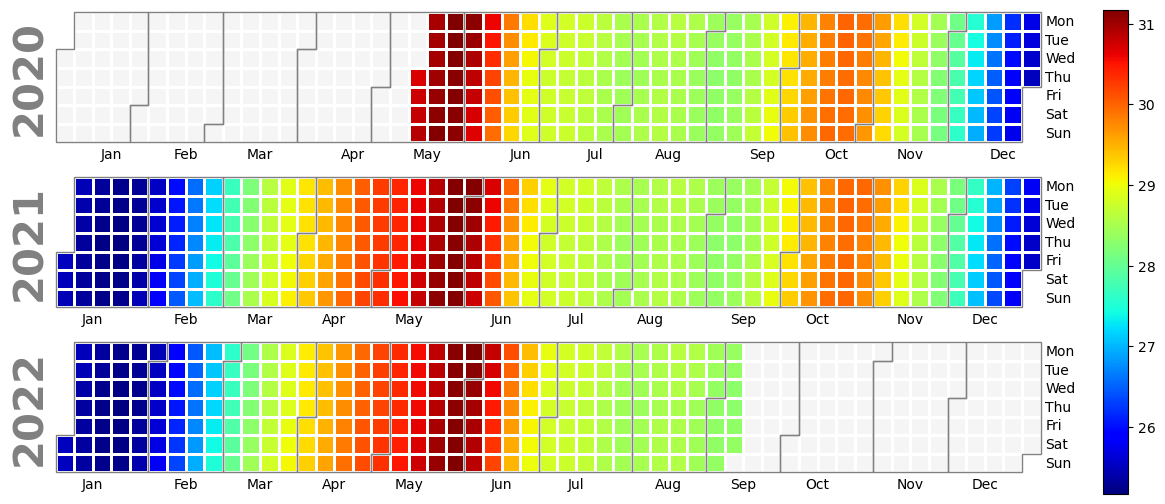

In [73]:
fig2 = calplot.calplot(pred["yhat"], how = "mean", cmap='jet')

# Performnce Measurement of the Model

In [74]:
df_cv = cross_validation(model, initial='1095 days', period='180 days', horizon = '365 days')


  0%|          | 0/44 [00:00<?, ?it/s]

19:21:32 - cmdstanpy - INFO - Chain [1] start processing
19:21:32 - cmdstanpy - INFO - Chain [1] done processing
19:21:33 - cmdstanpy - INFO - Chain [1] start processing
19:21:34 - cmdstanpy - INFO - Chain [1] done processing
19:21:35 - cmdstanpy - INFO - Chain [1] start processing
19:21:35 - cmdstanpy - INFO - Chain [1] done processing
19:21:36 - cmdstanpy - INFO - Chain [1] start processing
19:21:37 - cmdstanpy - INFO - Chain [1] done processing
19:21:38 - cmdstanpy - INFO - Chain [1] start processing
19:21:39 - cmdstanpy - INFO - Chain [1] done processing
19:21:40 - cmdstanpy - INFO - Chain [1] start processing
19:21:40 - cmdstanpy - INFO - Chain [1] done processing
19:21:41 - cmdstanpy - INFO - Chain [1] start processing
19:21:42 - cmdstanpy - INFO - Chain [1] done processing
19:21:43 - cmdstanpy - INFO - Chain [1] start processing
19:21:44 - cmdstanpy - INFO - Chain [1] done processing
19:21:45 - cmdstanpy - INFO - Chain [1] start processing
19:21:46 - cmdstanpy - INFO - Chain [1]

In [75]:
df_cv

ds       yhat  yhat_lower  yhat_upper          y     cutoff
0     1998-03-06  27.573731   25.993471   29.212701  24.777778 1998-03-05
1     1998-03-07  27.859227   26.286426   29.391957  25.722222 1998-03-05
2     1998-03-08  28.145410   26.630302   29.754751  25.444444 1998-03-05
3     1998-03-09  28.323002   26.592325   29.840125  25.166667 1998-03-05
4     1998-03-10  28.430699   26.823558   30.024045  27.388889 1998-03-05
...          ...        ...         ...         ...        ...        ...
15994 2020-05-09  30.749983   28.996810   32.578205  30.722222 2019-05-14
15995 2020-05-10  30.790423   29.014024   32.431138  30.944444 2019-05-14
15996 2020-05-11  30.852900   29.068074   32.575683  31.166667 2019-05-14
15997 2020-05-12  30.886937   29.318372   32.614026  30.722222 2019-05-14
15998 2020-05-13  30.907265   29.040190   32.802001  29.444444 2019-05-14

[15999 rows x 6 columns]

In [76]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon       mse      rmse       mae      mape     mdape     smape  \
0 37 days  2.564819  1.601505  1.239480  0.046588  0.037117  0.046250   
1 38 days  2.541817  1.594308  1.233926  0.046423  0.037052  0.046064   
2 39 days  2.531005  1.590913  1.231959  0.046361  0.036959  0.045992   
3 40 days  2.519149  1.587183  1.229217  0.046250  0.036846  0.045877   
4 41 days  2.506398  1.583161  1.223497  0.046027  0.036536  0.045649   

   coverage  
0  0.751094  
1  0.753120  
2  0.752811  
3  0.753538  
4  0.755254

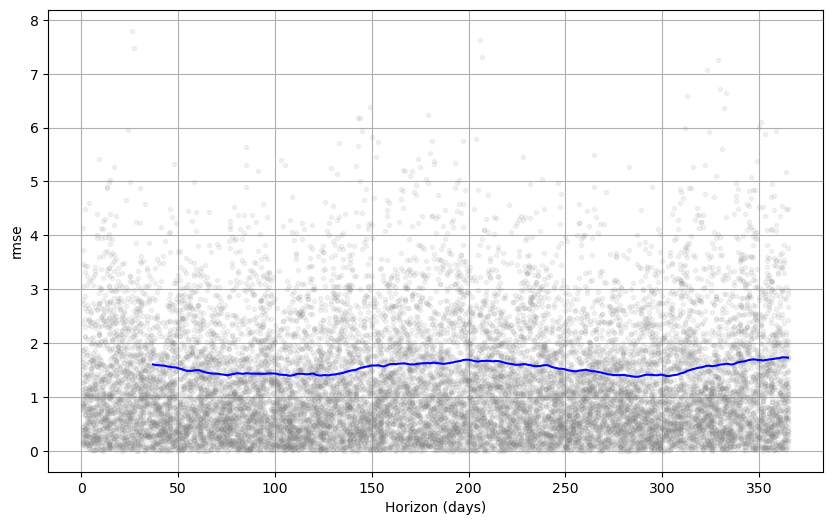

In [77]:
figure3 = plot_cross_validation_metric(df_cv, metric='rmse')